In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [3]:
lines = open('input.txt', 'r').read()

In [4]:
vocab = sorted(list(set(lines)))

In [5]:
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

### Character-level tokenizer

In [8]:
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join(itos[i] for i in l)

print(f'vocab size: {len(vocab)}')
decode(encode('hello'))

vocab size: 65


'hello'

In [10]:
MASTER_CONFIG = {
    'vocab_size': len(vocab),
}

In [11]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)

In [13]:
dataset.shape  # 1115394 rows

torch.Size([1115394])

In [14]:
train = dataset[:int(len(dataset)*0.8)]

In [15]:
batch_data = train

In [22]:
batch_size, context_window = 8, 16 
ix = torch.randint(0, len(batch_data) - context_window + 1, (batch_size,))

In [25]:
x = [batch_data[i:i+context_window] for i in ix]

In [26]:
x 

[tensor([46, 43, 52,  1, 46, 43,  1, 46, 39, 42,  1, 41, 39, 56, 56, 47],
        dtype=torch.int8),
 tensor([50, 50,  1, 54, 39, 56, 42, 53, 52,  1, 51, 43,  8,  0,  0, 16],
        dtype=torch.int8),
 tensor([39, 58, 46, 43, 56,  1, 40, 59, 58,  1, 58, 46, 43,  1, 57, 53],
        dtype=torch.int8),
 tensor([30, 21, 27, 24, 13, 26, 33, 31, 10,  0, 35, 43, 50, 50,  6,  1],
        dtype=torch.int8),
 tensor([57, 54, 39, 56, 43,  1, 58, 53,  1, 45, 47, 56, 42,  1, 58, 46],
        dtype=torch.int8),
 tensor([ 1, 58, 53, 61, 39, 56, 42,  1, 17, 52, 45, 50, 39, 52, 42,  6],
        dtype=torch.int8),
 tensor([61, 53, 56, 43,  1, 41, 53, 52, 57, 43, 52, 58,  1, 58, 53,  1],
        dtype=torch.int8),
 tensor([ 1, 42, 43, 52, 63,  1, 58, 53,  1, 46, 47, 51,  1, 58, 46, 39],
        dtype=torch.int8)]

In [29]:
torch.stack(x).long()

tensor([[46, 43, 52,  1, 46, 43,  1, 46, 39, 42,  1, 41, 39, 56, 56, 47],
        [50, 50,  1, 54, 39, 56, 42, 53, 52,  1, 51, 43,  8,  0,  0, 16],
        [39, 58, 46, 43, 56,  1, 40, 59, 58,  1, 58, 46, 43,  1, 57, 53],
        [30, 21, 27, 24, 13, 26, 33, 31, 10,  0, 35, 43, 50, 50,  6,  1],
        [57, 54, 39, 56, 43,  1, 58, 53,  1, 45, 47, 56, 42,  1, 58, 46],
        [ 1, 58, 53, 61, 39, 56, 42,  1, 17, 52, 45, 50, 39, 52, 42,  6],
        [61, 53, 56, 43,  1, 41, 53, 52, 57, 43, 52, 58,  1, 58, 53,  1],
        [ 1, 42, 43, 52, 63,  1, 58, 53,  1, 46, 47, 51,  1, 58, 46, 39]],
       dtype=torch.int8)

In [32]:
def get_one_batch(data, split, config=MASTER_CONFIG):
    batch_size, context_window = config['batch_size'], config['context_window']
    train = data[:int(.8*len(data))]
    val = data[int(.8*len(data)): int(.9*len(data))]
    test = data[int(.9*len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test
    
    ix = torch.randint(0, len(batch_data) - context_window, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y

MASTER_CONFIG.update({
    "batch_size": 8,
    "context_window": 16
})

In [33]:
xs, ys = get_one_batch(dataset, 'train')

In [37]:
[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[(" seat o' the bra", "seat o' the brai"),
 ("od, 'tis shame s", "d, 'tis shame su"),
 (' not delay the p', 'not delay the pr'),
 ('s, disdains the ', ', disdains the s'),
 (' I now must make', 'I now must make '),
 ('th me: it will i', 'h me: it will in'),
 ('ean to take poss', 'an to take posse'),
 (' your father gro', 'your father grow')]

In [60]:
@torch.no_grad
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = []
        for _ in range(10):
            xb, yb = get_one_batch(dataset, split, config=config)
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)

    model.train()
    return out

In [66]:
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.vocab_size, self.d_model = config['vocab_size'], config['d_model']

        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        self.linear = nn.Sequential(
            nn.Linear(self.d_model, self.d_model),
            nn.ReLU(),
            nn.Linear(self.d_model, self.vocab_size)
        )

        print(f"total model params: {sum([m.numel() for m in self.parameters()])}")
    
    def forward(self, ix, targets=None):
        """
        Shape of ix (batch_size, seq_len)
        Shape of x (batch_size, seq_len, d_model)
        Shape of logits (batch_size, seq_len, vocab_size)
        """
        x = self.embedding(ix)
        logits = self.linear(x)
        # logits = F.softmax(a, dim=-1)

        if targets is not None:
            # logits dim is batch_size * context_window * num_class
            # targets dim is batch_size * context_window. It gives (batch_size * context_window) labels.
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
            return logits, loss
        else:
            return logits

In [ ]:
MASTER_CONFIG.update({
    'd_model': 128
})
model = SimpleModel(config=MASTER_CONFIG)
xs, ys = get_one_batch(dataset, 'train', MASTER_CONFIG)
logits, loss = model(xs, ys)

In [192]:
xs.shape

torch.Size([32, 16])

In [68]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 100,
    'batch_size': 32
})
model = SimpleModel(config=MASTER_CONFIG)
optimizer = torch.optim.AdamW(params=model.parameters())

def train(model: SimpleModel, optimizer: torch.optim, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    start_time = time.time()
    losses = []
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        xs, ys = get_one_batch(dataset, 'train', config=config)
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            interval_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
        
            if print_logs:
                print(f"Epoch: {epoch} | val loss: {x['val']:.3f} | train loss: {x['train']:.3f} | time {interval_time:.3f} | ETA in seconds {interval_time * (config['epochs'] - epoch) / config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print(f"lr: {scheduler.get_lr()}")
            
    print(f"validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses)

total model params: 33217


In [69]:
losses = train(model, optimizer, print_logs=True)

Epoch: 0 | val loss: 4.159 | train loss: 4.157 | time 0.005 | ETA in seconds 0.048
Epoch: 100 | val loss: 2.662 | train loss: 2.605 | time 0.178 | ETA in seconds 1.598
Epoch: 200 | val loss: 2.556 | train loss: 2.534 | time 0.145 | ETA in seconds 1.157
Epoch: 300 | val loss: 2.536 | train loss: 2.498 | time 0.132 | ETA in seconds 0.927
Epoch: 400 | val loss: 2.520 | train loss: 2.491 | time 0.139 | ETA in seconds 0.832
Epoch: 500 | val loss: 2.557 | train loss: 2.478 | time 0.158 | ETA in seconds 0.790
Epoch: 600 | val loss: 2.527 | train loss: 2.485 | time 0.154 | ETA in seconds 0.617
Epoch: 700 | val loss: 2.496 | train loss: 2.469 | time 0.148 | ETA in seconds 0.443
Epoch: 800 | val loss: 2.495 | train loss: 2.479 | time 0.155 | ETA in seconds 0.310
Epoch: 900 | val loss: 2.502 | train loss: 2.469 | time 0.150 | ETA in seconds 0.150
validation loss: 2.50212562084198


<Axes: >

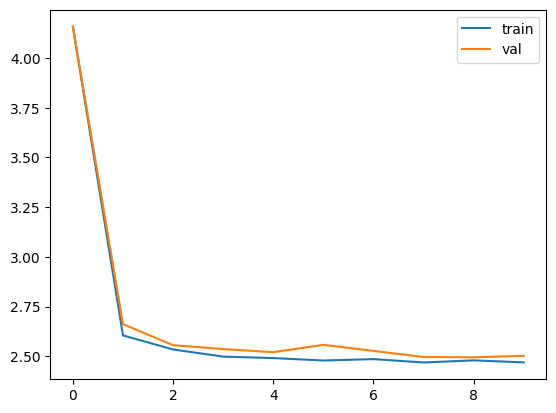

In [70]:
losses.plot()

In [158]:
def generate(model, config=MASTER_CONFIG, max_tokens=32):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_tokens):
        logits = model(idx[:, -config['context_window']:])
        last_time_step = logits[:, -1, :]
        p = F.softmax(last_time_step, dim=-1)
        idx_next = torch.multinomial(p, num_samples=1)
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

In [161]:
outputs = generate(model)
for out in outputs:
    print(out)


Wis bll!
S: HELINRoner s f ith d

MI t tuthat w.
iecon Of h.
Wat I

D thaw'ds thethanny; this the th



AF y.
TUSu be m houls ou d t d

Tyblave om tie farfoorhitousutad


In [155]:
config = MASTER_CONFIG
logits = model(idx[:, -config['context_window']:])

In [76]:
last_time_step_logits = logits[
    :, -1, :
]  # all the batches (1), last time step, all the logits
p = F.softmax(last_time_step_logits, dim=-1)

In [89]:
torch.multinomial(
    p, num_samples=1
)  # sample from the distribution to get the next token

tensor([[14],
        [15],
        [33],
        [ 0],
        [19]])

In [95]:
p[0][19]

tensor(0.0163, grad_fn=<SelectBackward0>)

In [137]:
p = torch.tensor([0.7, 0.3, 0.0], dtype=torch.float)
torch.multinomial(p, 2)

tensor([0, 1])

In [147]:
torch.stack([idx, idx_next], dim=-1)

tensor([[[ 0, 13]],

        [[ 0, 31]],

        [[ 0, 32]],

        [[ 0, 21]],

        [[ 0, 32]]])

In [148]:
torch.stack([idx, idx_next], dim=-1).shape

torch.Size([5, 1, 2])

In [156]:
idx = torch.cat([idx, idx_next], dim=-1)

In [151]:
torch.cat([idx, idx_next], dim=-1).shape

torch.Size([5, 2])

In [157]:
idx.tolist()

[[0, 13], [0, 31], [0, 32], [0, 21], [0, 32]]

### RMS Norm

In [169]:
x = torch.randint(0, 5, (5, 3, 4)).float()

In [175]:
ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

In [176]:
x

tensor([[[1., 4., 0., 2.],
         [1., 3., 1., 3.],
         [0., 0., 1., 2.]],

        [[1., 4., 3., 2.],
         [0., 1., 4., 0.],
         [3., 2., 1., 0.]],

        [[3., 1., 0., 4.],
         [2., 4., 3., 2.],
         [0., 0., 0., 4.]],

        [[1., 3., 3., 3.],
         [3., 3., 0., 2.],
         [3., 2., 3., 0.]],

        [[3., 3., 0., 2.],
         [1., 0., 4., 3.],
         [0., 1., 3., 1.]]])

In [177]:
ff_rms

tensor([1.9579, 2.2546, 2.5000, 2.4495, 2.2174])

In [178]:
x / ff_rms.unsqueeze(-1).unsqueeze(-1)

tensor([[[0.5108, 2.0430, 0.0000, 1.0215],
         [0.5108, 1.5323, 0.5108, 1.5323],
         [0.0000, 0.0000, 0.5108, 1.0215]],

        [[0.4435, 1.7741, 1.3306, 0.8871],
         [0.0000, 0.4435, 1.7741, 0.0000],
         [1.3306, 0.8871, 0.4435, 0.0000]],

        [[1.2000, 0.4000, 0.0000, 1.6000],
         [0.8000, 1.6000, 1.2000, 0.8000],
         [0.0000, 0.0000, 0.0000, 1.6000]],

        [[0.4082, 1.2247, 1.2247, 1.2247],
         [1.2247, 1.2247, 0.0000, 0.8165],
         [1.2247, 0.8165, 1.2247, 0.0000]],

        [[1.3530, 1.3530, 0.0000, 0.9020],
         [0.4510, 0.0000, 1.8040, 1.3530],
         [0.0000, 0.4510, 1.3530, 0.4510]]])

In [202]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape):
        # layer_shape is (seq_len, d_model)
        # the scaling factor is applied to all batches
        super().__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))
    
    def forward(self, x):
        """
        Shape of x is (batch_size, seq_len, d_model)
        """
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [180]:
config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

In [184]:
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch[0].numel() ** -.5

In [185]:
# for one batch, unsqueeze is not needed. 
batch[0] / ff_rms[0]

tensor([[ 1.3443e-01, -2.9638e-01, -1.3977e+00,  1.3963e+00, -2.0000e+00,
         -5.9304e-01,  4.3997e-01,  1.5740e+00, -9.7514e-03, -4.8573e-01,
         -1.3366e+00,  4.9036e-01, -8.8915e-01],
        [ 4.0329e-02,  1.0306e+00,  4.4480e-01,  6.1821e-01,  1.3803e+00,
          1.2451e-01,  9.3954e-01, -1.2167e+00, -2.6760e-01,  2.8509e-02,
          1.0370e+00,  1.0954e-01,  2.0873e+00],
        [ 1.0333e+00,  5.0350e-02, -4.7132e-01, -1.2846e+00,  1.4021e-01,
         -2.1505e+00, -1.1941e+00,  6.1587e-02, -2.1502e-01,  4.6562e-01,
          4.2275e-01,  6.5392e-01,  1.1359e+00],
        [-8.3041e-01, -1.3419e+00, -3.0656e-01, -7.0560e-01,  4.3351e-01,
          1.3750e-01,  7.0363e-01, -9.7270e-01, -4.5540e-01,  1.8967e+00,
          9.2095e-01, -8.7178e-01, -2.6706e+00],
        [ 6.8348e-01, -2.0438e+00,  8.3791e-01, -1.2727e-01,  1.1058e+00,
          7.4353e-01,  1.4335e+00, -1.7884e-01,  1.0324e+00,  1.1913e+00,
          9.0102e-01,  6.5475e-01,  2.3049e-01],
        [ 6.945

model params: 35265
Epoch: 0 | val loss: 4.129 | train loss: 4.122 | time 0.003 | ETA in seconds 0.027
Epoch: 100 | val loss: 2.637 | train loss: 2.597 | time 0.200 | ETA in seconds 1.801
Epoch: 200 | val loss: 2.554 | train loss: 2.515 | time 0.184 | ETA in seconds 1.475
Epoch: 300 | val loss: 2.547 | train loss: 2.487 | time 0.191 | ETA in seconds 1.335
Epoch: 400 | val loss: 2.537 | train loss: 2.475 | time 0.217 | ETA in seconds 1.301
Epoch: 500 | val loss: 2.523 | train loss: 2.501 | time 0.212 | ETA in seconds 1.062
Epoch: 600 | val loss: 2.541 | train loss: 2.470 | time 0.206 | ETA in seconds 0.823
Epoch: 700 | val loss: 2.511 | train loss: 2.487 | time 0.196 | ETA in seconds 0.589
Epoch: 800 | val loss: 2.524 | train loss: 2.456 | time 0.207 | ETA in seconds 0.414
Epoch: 900 | val loss: 2.527 | train loss: 2.490 | time 0.204 | ETA in seconds 0.204
validation loss: 2.527190065383911


<Axes: >

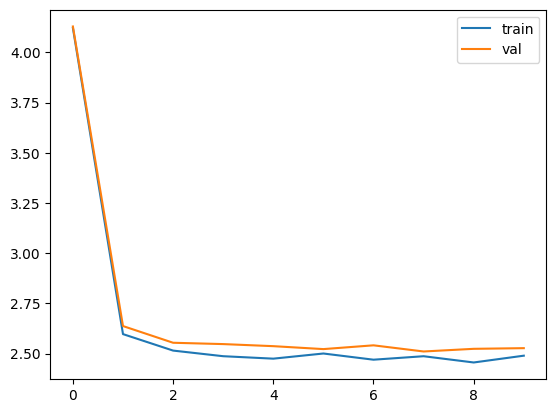

In [206]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.batch_size, self.context_window, self.d_model, self.vocab_size = config['batch_size'], config['context_window'], config['d_model'], config['vocab_size']
        
        # in: (batch_size, seq_len), out: (batch_size, seq_len, d_model)
        self.embedding = nn.Embedding(self.vocab_size, self.d_model)
        # in: (batch_size, seq_len, d_model), out: (batch_size, seq_len, d_model)
        self.rms = RMSNorm((self.context_window, self.d_model))
        # in: (batch_size, seq_len, d_model), out: (batch_size, seq_len, vocab_size)
        self.linear = nn.Sequential(
            nn.Linear(self.d_model ,self.d_model),
            nn.ReLU(),
            nn.Linear(self.d_model, self.vocab_size)
        )

        print(f"model params: {sum(m.numel() for m in self.parameters())}")
    
    def forward(self, ix, targets=None):
        x = self.embedding(ix)
        x = self.rms(x)
        logits = self.linear(x)

        if targets != None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
            return logits, loss
        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_one_batch(dataset, 'train', config=MASTER_CONFIG)

logits, loss = model(xs, ys)
optimizer = torch.optim.AdamW(model.parameters())
losses = train(model, optimizer, print_logs=True)
losses.plot()


In [211]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000 ** (-2.*(i-1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i, 2*i] = np.cos(m_theta)
            R[position, 2*i, 2*i+1] = -np.sin(m_theta)
            R[position, 2*i+1, 2*i] = np.sin(m_theta)
            R[position, 2*i+1, 2*i+1] = np.cos(m_theta)
    return R

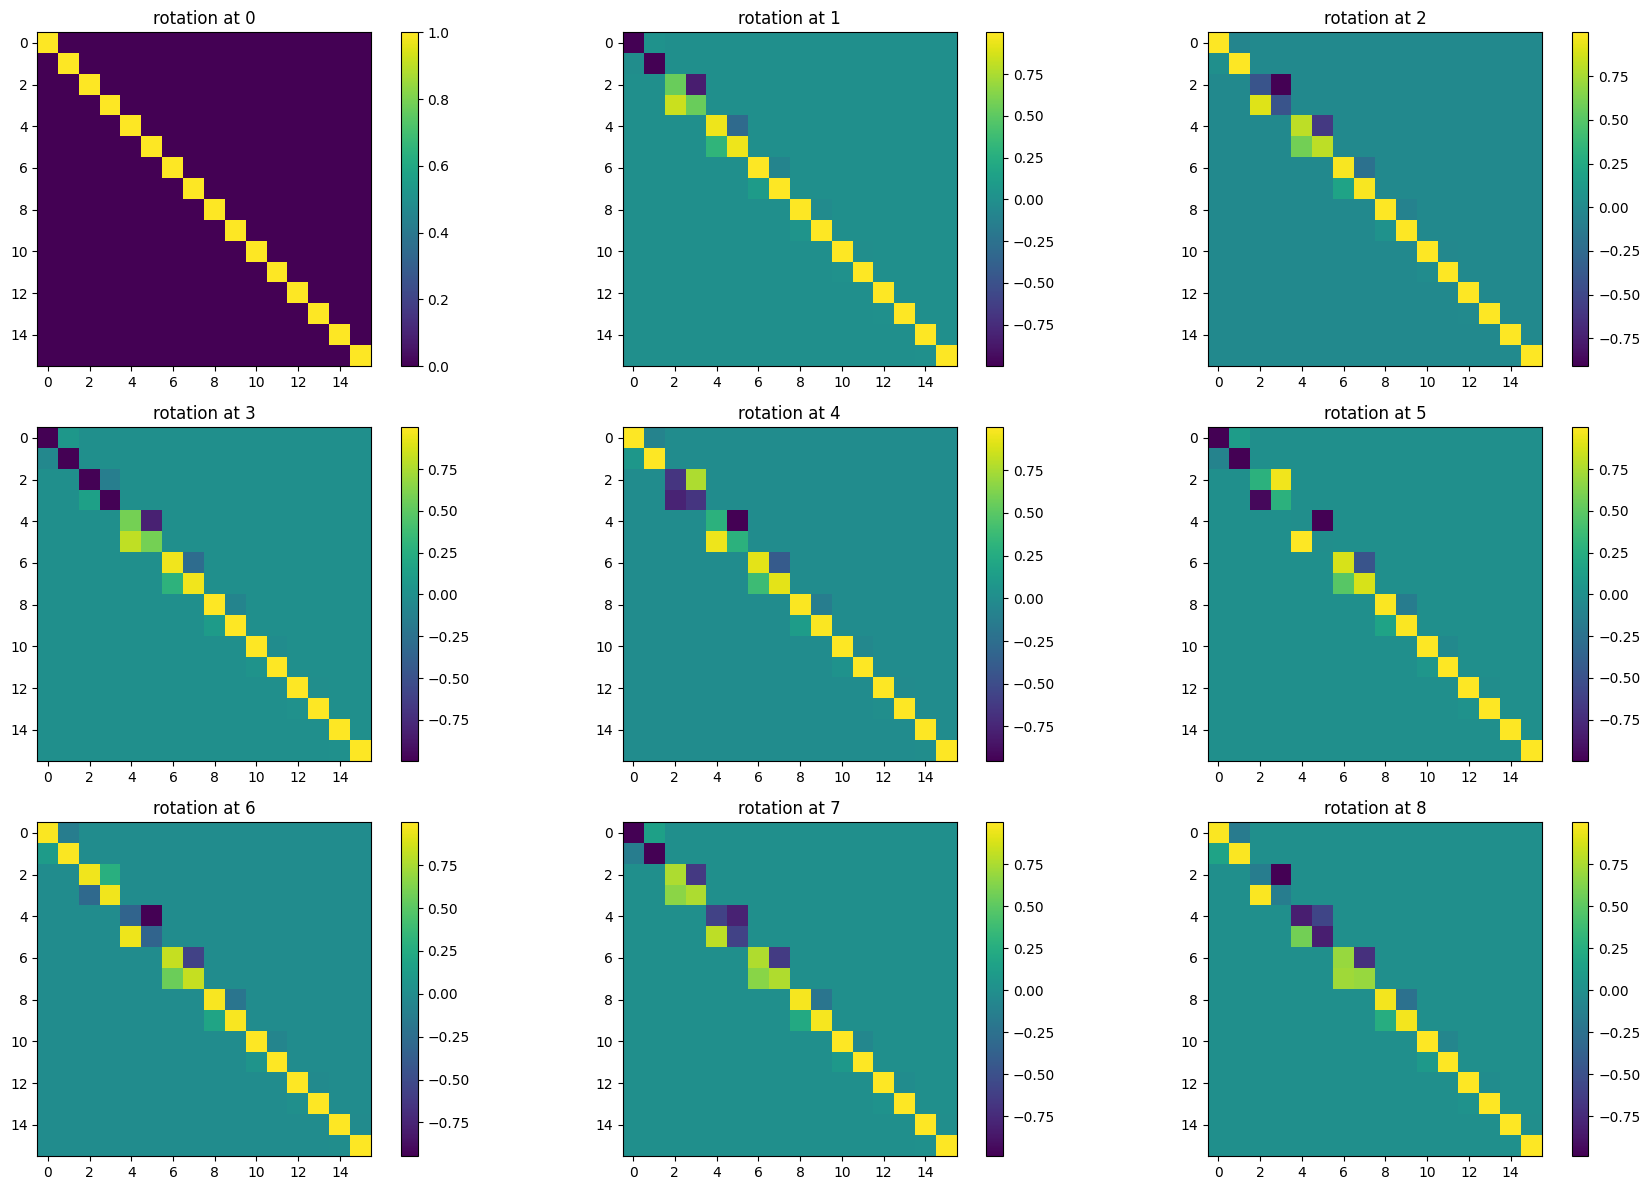

In [309]:
K = 3
context_window, embedding_dim = K ** 2, 16
R = get_rotary_matrix(context_window, embedding_dim)
fig, ax = plt.subplots(K, K, figsize=(K*6, K*4))

for i in range(K):
    for j in range(K):
        # plt.imshow(R[i*K+j,:,:].detach().numpy(), interpolation='nearest')
        cax = ax[i, j].imshow(R[i*K+j,:,:].detach().numpy(), interpolation='nearest', cmap='viridis')
        fig.colorbar(cax, ax=ax[i,j])
        ax[i, j].set_title(f"rotation at {i*K+j}")
        # plt.colorbar()
# plt.imshow(im, interpolation='nearest')
fig.tight_layout()
plt.show()

In [240]:
x_n, x_m = torch.randn(embedding_dim), torch.randn(embedding_dim)  # Shape is [embedding_dim], not [embedding_dim, 1]
m, n = 2, 6

assert torch.isclose((R[m,:,:] @ x_m) @ (R[n,:,:] @ x_n), x_m @ R[n-m,:,:] @ x_n)

In [251]:
config.update({
    'batch_size': 1,
    'context_window': 2,
    'd_model': 4
})

In [252]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

In [253]:
x.shape

torch.Size([1, 2, 4])

In [336]:
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        # Shape (seq_len, d_model, d_model)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def forward(self, x, return_attn_weights=False):
        # Shape (batch_size, seq_len, d_model)
        q, k, v = self.w_q(x), self.w_k(x), self.w_v(x)

        """
        q.transpose(0, 1) @ self.R[x.shape[1]:], output Shape is (seq_len, batch_size, d_model)
        in this scenario, position can be considered as "batch", for a fixed position, the rotary matrix is the same
        in dimension 1, 2, for each vector, we apply rotary matrix to it, for batch_size vectors
        """
        q_rotated = (q.transpose(0, 1) @ self.R[:x.shape[1]]).transpose(0,1)         # Shape (batch_size, seq_len, d_model)
        k_rotated = (k.transpose(0, 1) @ self.R[:x.shape[1]]).transpose(0,1)

        activations = F.scaled_dot_product_attention(q_rotated, k_rotated, v, dropout_p=.1, is_causal=True)

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones(x.shape[1], x.shape[1]), diagonal=0)
            # Attn Matrix Shape is (batch_size, seq_len, seq_len)
            """
            This addition masking approach can work because we normalized the embedding (input to the attn layer) so that it's always between (0,1)
            """
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(x.shape[-1]) + attn_mask  # Shape (batch_size, seq_len, seq_len)
            print(attn_weights)
            print(torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(x.shape[-1]))

            attn_weights = F.softmax(attn_weights, dim=-1)
            raw_attn_weights = F.softmax(torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(x.shape[-1]), dim=-1)
            # print(attn_weights)
            return activations, attn_weights, raw_attn_weights
        else:
            return activations

# layer = RoPEMaskedAttentionHead(config=config)
# batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
# output, attn_weights = layer(batch, return_attn_weights=True)

In [295]:
q = layer.w_q(x)
k = layer.w_k(x)
q_rotated = (q.transpose(0, 1) @ layer.R[:x.shape[1]]).transpose(0,1)
k_rotated = (k.transpose(0, 1) @ layer.R[:x.shape[1]]).transpose(0,1)
attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(x.shape[-1])
attn_weights

tensor([[[-0.1256, -0.5554],
         [ 0.4287, -0.5149]]], grad_fn=<DivBackward0>)

In [296]:
F.softmax(attn_weights, dim=-1)

tensor([[[0.6058, 0.3942],
         [0.7198, 0.2802]]], grad_fn=<SoftmaxBackward0>)

In [310]:
attn_weights_mask = torch.bmm(q_rotated, k_rotated.transpose(1,2)) / np.sqrt(x.shape[-1]) * torch.tril(torch.ones(x.shape[1], x.shape[1]), diagonal=0)
attn_weights_mask

tensor([[[-0.1256, -0.0000],
         [ 0.4287, -0.5149]]], grad_fn=<MulBackward0>)

In [311]:
F.softmax(attn_weights_mask, dim=-1)

tensor([[[0.4686, 0.5314],
         [0.7198, 0.2802]]], grad_fn=<SoftmaxBackward0>)

In [260]:
q[0]

tensor([[-0.0019,  0.0145,  0.2179,  0.2813],
        [ 0.6858,  0.1209, -1.3576,  0.3781]], grad_fn=<SelectBackward0>)

In [261]:
q.transpose(0,1)[0]

tensor([[-0.0019,  0.0145,  0.2179,  0.2813]], grad_fn=<SelectBackward0>)

In [262]:
R = layer.R

In [263]:
R.shape

torch.Size([2, 4, 4])

In [264]:
q_t = q.transpose(0, 1)

In [265]:
q_t.shape

torch.Size([2, 1, 4])

In [331]:
config.update({
    'context_window': 8
})

tensor([[[  9.3683,   6.6750,   4.3582,  -1.6262,  -7.1456,  -7.2565,  -3.4242,
           -5.5680],
         [  6.7866,  10.4204,  10.0725,   5.1151,  -3.5011,  -5.9123,  -3.0137,
           -6.7315],
         [  1.1984,   7.1292,   9.8714,   5.6913,  -0.1563,  -0.4732,   1.8345,
            0.2070],
         [ -0.4119,   3.2403,   5.0140,   9.3683,   6.3752,   0.1276,  -4.7657,
           -8.3953],
         [ -4.4309,  -3.5957,  -5.4923,   2.8395,  20.8986,  20.6824,   2.4668,
           -0.1555],
         [ -1.8368,   0.5909,  -0.7377,  -4.3042,   9.7107,  21.2377,  13.5651,
           15.1959],
         [ -5.6998,   2.1509,   7.7169,   0.6615,  -3.1719,   6.2140,  16.0383,
           20.4365],
         [-15.7454,  -9.1258,  -1.4626,   3.6300,   5.3789,   9.2522,  13.0918,
           20.3480]]], grad_fn=<AddBackward0>)
tensor([[[  8.3683,   6.6750,   4.3582,  -1.6262,  -7.1456,  -7.2565,  -3.4242,
           -5.5680],
         [  5.7866,   9.4204,  10.0725,   5.1151,  -3.5011,  -5.9

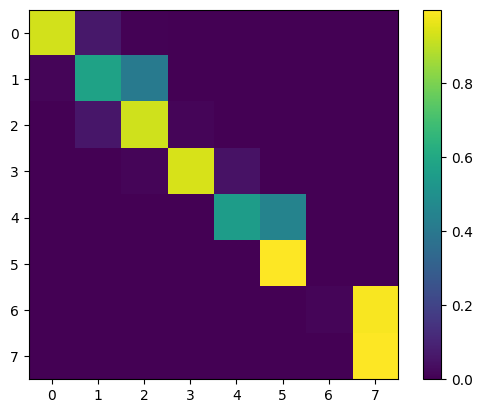

In [340]:
layer = RoPEMaskedAttentionHead(config)
batch = torch.randint(1, 10, (config['batch_size'], config['context_window'], config['d_model'])).float()
output, attn_weights, raw_attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [334]:
attn_weights[0]

tensor([[0.2762, 0.1021, 0.0756, 0.1453, 0.0652, 0.0784, 0.1468, 0.1104],
        [0.2241, 0.2575, 0.0639, 0.0781, 0.0896, 0.0772, 0.1153, 0.0943],
        [0.2057, 0.2146, 0.2036, 0.0803, 0.0705, 0.0700, 0.0797, 0.0756],
        [0.1758, 0.2007, 0.1410, 0.1724, 0.0854, 0.0842, 0.0683, 0.0722],
        [0.1579, 0.1833, 0.1584, 0.1506, 0.1736, 0.0550, 0.0622, 0.0590],
        [0.1818, 0.0903, 0.1736, 0.1413, 0.1182, 0.1434, 0.0832, 0.0682],
        [0.1174, 0.2044, 0.1247, 0.1210, 0.1571, 0.1096, 0.1224, 0.0433],
        [0.1200, 0.1452, 0.1275, 0.1223, 0.1329, 0.1186, 0.1156, 0.1178]],
       grad_fn=<SelectBackward0>)

In [335]:
raw_attn_weights[0]

tensor([[0.1231, 0.1237, 0.0916, 0.1761, 0.0790, 0.0950, 0.1778, 0.1337],
        [0.1185, 0.1362, 0.0919, 0.1123, 0.1288, 0.1111, 0.1657, 0.1356],
        [0.1250, 0.1303, 0.1237, 0.1326, 0.1165, 0.1155, 0.1316, 0.1248],
        [0.1147, 0.1309, 0.0920, 0.1125, 0.1515, 0.1493, 0.1212, 0.1280],
        [0.1212, 0.1407, 0.1216, 0.1156, 0.1332, 0.1147, 0.1298, 0.1232],
        [0.1443, 0.0717, 0.1377, 0.1122, 0.0938, 0.1138, 0.1794, 0.1471],
        [0.1093, 0.1902, 0.1161, 0.1127, 0.1462, 0.1020, 0.1139, 0.1096],
        [0.1200, 0.1452, 0.1275, 0.1223, 0.1329, 0.1186, 0.1156, 0.1178]],
       grad_fn=<SelectBackward0>)

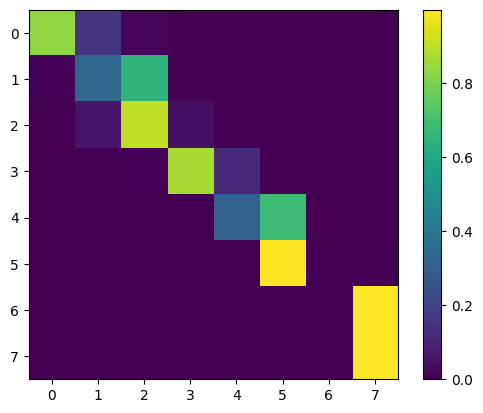

In [341]:
plt.imshow(raw_attn_weights[0].detach().numpy())
plt.colorbar()

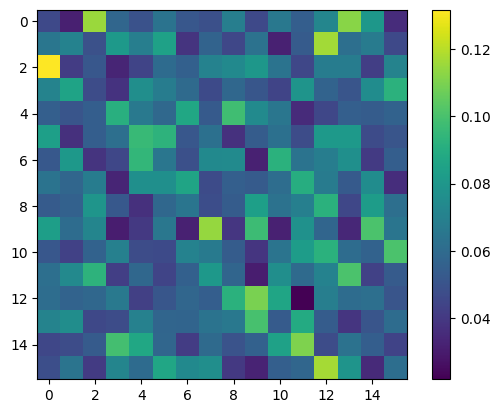

In [320]:
layer = RoPEAttentionHead(MASTER_CONFIG)
batch = torch.randn((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

In [314]:
class RoPEMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['d_model']*config['n_heads'], config['d_model'])
        self.dropout = nn.Dropout(.1)
    
    def forward(self, x):
        heads = [h(x) for h in self.heads]
        x = self.linear(torch.cat(heads, dim=-1))
        x = self.dropout(x)
        return x

In [269]:
config.update({
    'n_heads': 8
})

layer = RoPEMultiheadAttention(config)
x = torch.randn(config['batch_size'], config['context_window'], config['d_model'])

In [271]:
heads = [h(x) for h in layer.heads]

In [275]:
torch.cat(heads, dim=-1).shape

torch.Size([1, 2, 32])

model params: 559681
Epoch: 0 | val loss: 4.186 | train loss: 4.214 | time 0.023 | ETA in seconds 2.302
Epoch: 50 | val loss: 2.588 | train loss: 2.614 | time 1.183 | ETA in seconds 117.159
Epoch: 100 | val loss: 2.465 | train loss: 2.401 | time 0.975 | ETA in seconds 95.594
Epoch: 150 | val loss: 2.363 | train loss: 2.355 | time 0.976 | ETA in seconds 94.685
Epoch: 200 | val loss: 2.341 | train loss: 2.255 | time 1.022 | ETA in seconds 98.158
Epoch: 250 | val loss: 2.287 | train loss: 2.207 | time 0.973 | ETA in seconds 92.439
Epoch: 300 | val loss: 2.298 | train loss: 2.178 | time 0.972 | ETA in seconds 91.406
Epoch: 350 | val loss: 2.229 | train loss: 2.175 | time 0.969 | ETA in seconds 90.071
Epoch: 400 | val loss: 2.217 | train loss: 2.158 | time 0.966 | ETA in seconds 88.860
Epoch: 450 | val loss: 2.214 | train loss: 2.109 | time 0.964 | ETA in seconds 87.756
Epoch: 500 | val loss: 2.196 | train loss: 2.122 | time 0.943 | ETA in seconds 84.869
Epoch: 550 | val loss: 2.169 | train

<Axes: >

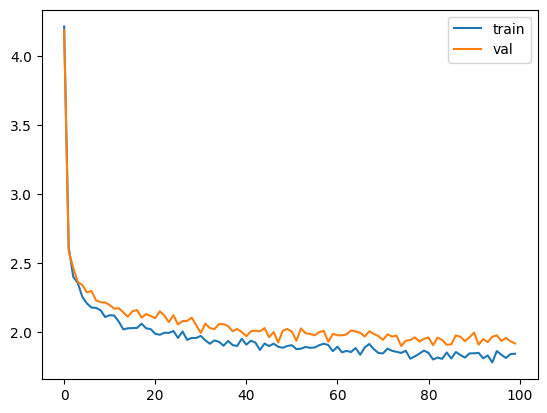

In [344]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'n_heads': 8,
    'epochs': 5000,
    'log_interval': 50
})

model = RopeModel(MASTER_CONFIG)
xs, ys = get_one_batch(dataset, 'train', MASTER_CONFIG)

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
losses = train(model, optimizer, print_logs=True)
losses.plot()

In [345]:
generate(model, config=MASTER_CONFIG)

['\nBut to his but.\n\nPORITY RK:\nYe a',
 '\nHo lime.\n\nPERMWIOur morrind; sur',
 '\nHold home, I dead noteundes thre',
 '\nThe me tend aly sham, leave, as ',
 '\n\nYou go:\nMy by more, sat ito sha']

In [289]:
attn_weights

tensor([[[0.5392, 0.4608],
         [0.6030, 0.3970]]], grad_fn=<SoftmaxBackward0>)

In [ ]:
m = attn_weights.shape[0]
attn_mask = torch.tril(torch.ones(m, m), diagonal=0)

In [346]:
class LlamaBlock(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.attention = RoPEMultiheadAttention(config)
        self.ff = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)  # residual connection

        x = self.rms(x)
        x = x + self.ff(x)
        return x

In [353]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4
})

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )

        print(f"model params: {sum([n.numel() for n in self.parameters()])}")
    
    def forward(self, x, targets=None):
        x = self.embedding(x)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets != None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
losses = train(llama, optimizer, config=MASTER_CONFIG, print_logs=True)

model params: 2205121
Epoch: 0 | val loss: 3.920 | train loss: 3.920 | time 0.099 | ETA in seconds 9.874
Epoch: 50 | val loss: 2.556 | train loss: 2.571 | time 4.161 | ETA in seconds 411.933
Epoch: 100 | val loss: 2.409 | train loss: 2.389 | time 4.163 | ETA in seconds 407.962
Epoch: 150 | val loss: 2.323 | train loss: 2.232 | time 4.022 | ETA in seconds 390.112
Epoch: 200 | val loss: 2.222 | train loss: 2.208 | time 3.685 | ETA in seconds 353.770
Epoch: 250 | val loss: 2.201 | train loss: 2.148 | time 3.731 | ETA in seconds 354.442
Epoch: 300 | val loss: 2.194 | train loss: 2.179 | time 3.980 | ETA in seconds 374.143
Epoch: 350 | val loss: 2.187 | train loss: 2.090 | time 4.816 | ETA in seconds 447.870
Epoch: 400 | val loss: 2.125 | train loss: 2.074 | time 4.354 | ETA in seconds 400.523
Epoch: 450 | val loss: 2.124 | train loss: 2.035 | time 3.615 | ETA in seconds 329.001
Epoch: 500 | val loss: 2.112 | train loss: 2.009 | time 3.737 | ETA in seconds 336.302
Epoch: 550 | val loss: 2.0

<Axes: >

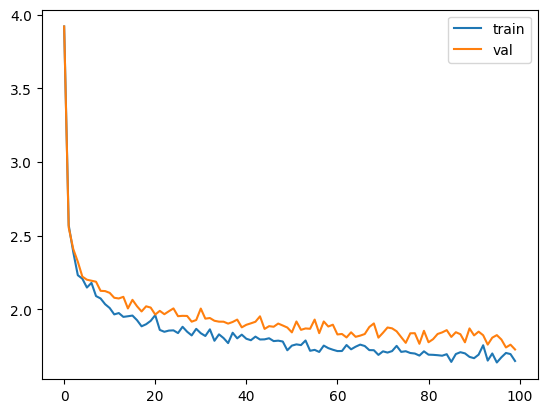

In [354]:
losses.plot()

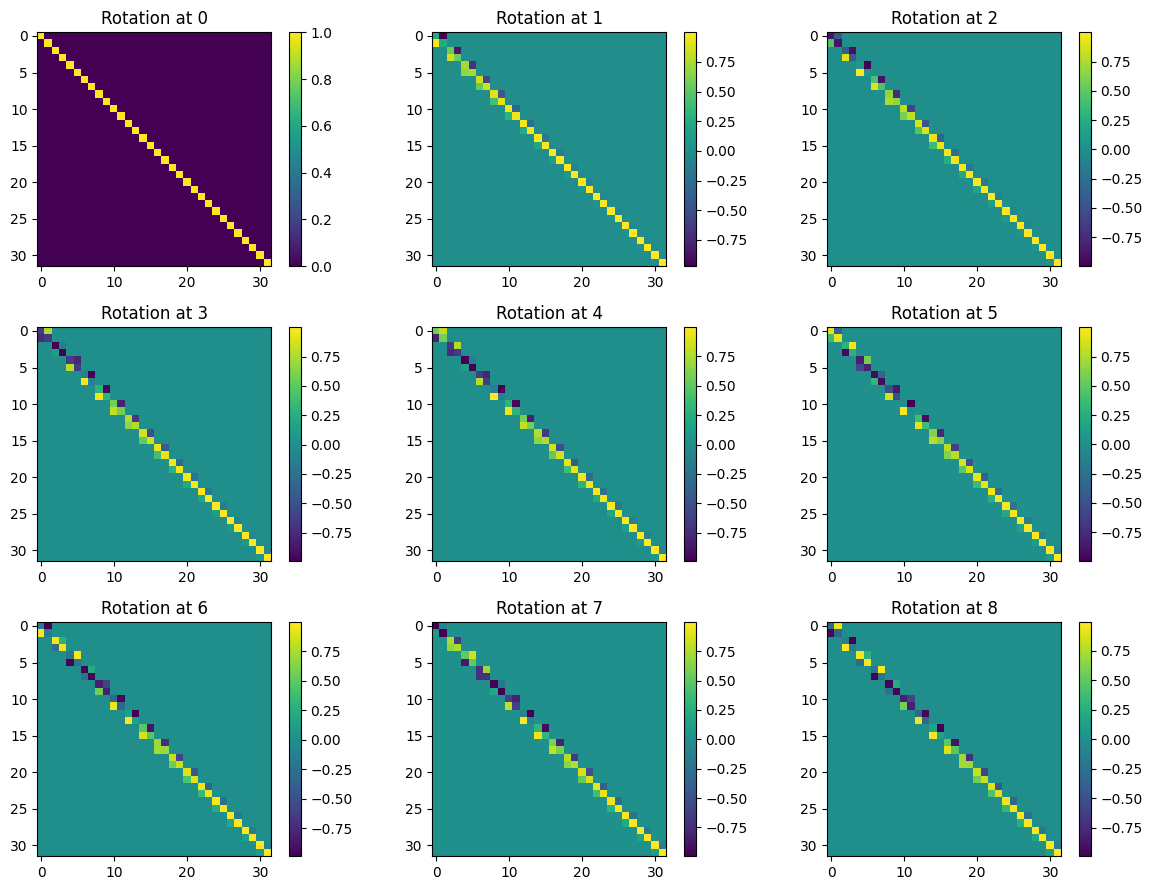

In [367]:
# get one batch
def get_one_batch(data, split, batch_size, context_window):
    return None

# evaluate loss
@torch.no_grad
def evaluate_loss(model, n, config=MASTER_CONFIG):
    '''
    Get train and val loss for X batches, get the average
    '''
    model.eval()
    out = {}
    for split in ['train', 'val']:
        losses = []
        for _ in range(n):
            xs, ys = get_one_batch(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xs, ys)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

# train
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in config['epochs']:
        optimizer.zero_grad()
        xs, yx = get_one_batch(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, yx)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            x = evaluate_loss(model, 10, config)
            batch_time = time.time() - start_time
            losses.append(x)
            if print_logs:
                print(f"epoch: {epoch} | val loss: {x['val']:.3f} | train loss: {x['train']:.3f} | time: {batch_time:.3f} | ETA in seconds: {(config['epochs']-epoch)/config['log_interval']*batch_time :.3f}")
                if scheduler:
                    print(f"lr: {scheduler.get_lr()}")
            start_time = time.time()
    print(f"validation loss: {losses[-1]['val']}")
    return pd.DataFrame(losses).plot()

# simple model
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )

        print(f"model params: {sum([n.numel() for n in self.parameters()])}")

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits

# get rotary matrix
def get_rotary_matrix(seq_len, d_model):
    R = torch.zeros((seq_len, d_model, d_model), requires_grad=False)
    for position in range(seq_len):
        for i in range(d_model // 2):
            theta = 10000 ** (-(i-1)*2./d_model)
            m_theta = position * theta
            R[position, 2*i, 2*i] = np.cos(m_theta)
            R[position, 2*i, 2*i+1] = -np.sin(m_theta)
            R[position, 2*i+1, 2*i] = np.sin(m_theta)
            R[position, 2*i+1, 2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(9, 32)

fig, ax = plt.subplots(K, K, figsize=(4*K, 3*K))
for i in range(K):
    for j in range(K):
        cax = ax[i,j].imshow(R[i*K+j,:,:].detach().numpy(), interpolation="nearest")
        ax[i,j].set_title(f"Rotation at {i*K+j}")
        plt.colorbar(cax)
fig.tight_layout()
plt.show()

# masked multihead attention



# one llama block 





In [374]:
model = SimpleModel(config=MASTER_CONFIG)
idx = torch.randint(0, MASTER_CONFIG['vocab_size'], (MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window']))
logits = model(idx)

model params: 33217


In [376]:
from torchviz import make_dot
dot = make_dot(logits, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")


'model_architecture.png'